<a href="https://colab.research.google.com/github/LuisRobles18/CSC8220/blob/main/CSC8820_Project_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**By:** Luis Alberto Robles Hernandez

**Student ID:** 002581393

#**Importing modules**

All the required modules are imported in this section

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import os
import warnings
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
%matplotlib inline

#**Reading dataset and preparing data**

**NOTE:** Before starting building the Convolutional Neural Network, it is important to upload the *meetup_dataset.zip* file to the server. As an alternative, it can be downloaded by executing the following code:

In [ ]:
!gdown --id 1NaXMJvR2823AVoULyZV3w8BRqQGkqWk4

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1NaXMJvR2823AVoULyZV3w8BRqQGkqWk4
To: /content/meetup_dataset.zip
100% 1.71M/1.71M [00:00<00:00, 171MB/s]


The following dataset is publicly available for anyone. It consists of data crawled from a typical Event-based Social Network, Meetup.com. The statistics of the dataset are the following:

*   **Number of unique events:** 19,307
*   **Number of unique groups:** 602
*   **Number of unique members:** 24,591
*   **Number of unique RSVPs:** 126,813





In [ ]:
with zipfile.ZipFile("meetup_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

##**Exporting dataset to a dataframe**

Each of the following items previously listed are located in separated CSV files. Therefore, we will read each of these files on separated dataframes.

In [ ]:
df_events = pd.read_csv('meetup_dataset/meta-events.csv')
df_groups = pd.read_csv('meetup_dataset/meta-groups.csv')
df_members = pd.read_csv('meetup_dataset/meta-members.csv')
df_rsvp = pd.read_csv('meetup_dataset/rsvps.csv')

We remove all duplicates (if any) from the dataframes

In [ ]:
df_events = df_events.drop_duplicates()
df_groups = df_groups.drop_duplicates()
df_members = df_members.drop_duplicates()
df_rsvp = df_rsvp.drop_duplicates()

print("Total number of unique events: "+str(len(df_events)))
print("Total number of unique groups: "+str(len(df_groups)))
print("Total number of unique members: "+str(len(df_members)))
print("Total number of unique rsvps: "+str(len(df_rsvp)))

Total number of unique events: 19307
Total number of unique groups: 602
Total number of unique members: 24591
Total number of unique rsvps: 126813


##**Filtering data**

**Generating a single dataframe based on rsvp:** In this part of the code, we perform a join operation between the RSVPs and members table in order to filter out those members who attended less than 10 events.

In [ ]:
df_merged = df_rsvp.merge(df_members, on='member_id', how='left')
df_rsvps_per_member = df_merged.value_counts(subset=['member_id']).to_frame()
df_rsvps_per_member = df_rsvps_per_member[0].reset_index(name="count")
df_rsvps_per_member = df_rsvps_per_member[df_rsvps_per_member['count'] > 10]
frequent_members_list = df_rsvps_per_member['member_id'].to_list()
print("Number of members that attended at least on 10 events: "+str(len(frequent_members_list)))

df_merged = df_merged[df_merged['member_id'].isin(frequent_members_list)]
print("Total of unique RSVPs (only members attending at least 10 events): "+str(len(df_merged)))

Number of members that attended at least on 10 events: 2695
Total of unique RSVPs (only members attending at least 10 events): 71990


##**Merging the dataframes**

In this part, we perform join operations on the RSVPs dataframe with the member, group, and event dataframes.

In [ ]:
#Merging with the events dataframe in order to get all the details from the events
df_merged = df_merged.merge(df_events, on='event_id', how='left')
df_merged = df_merged.drop(['group_id_y'], axis=1)
df_merged.rename(columns = {"group_id_x": "group_id"}, inplace = True)
#Merging with the groups dataframe in order to get all the details from the group
df_merged = df_merged.merge(df_groups, on='group_id', how='left')
df_merged.head()

,rsvp_id,event_id,member_id,group_id,member_name,member_hometown,member_city,member_state,member_lat,member_lon,event_description,event_time,group_name,num_members,category_id,category_name,organizer_id,group_urlname
0,0,243930425,6770985,26140018,Joe,Nashville,Nashville,TN,36.16,-86.79,2017 Nashville Walk to End Alzheimers - Octob...,10/14/2017 12:00,Fight against Alzheimer’s Disease/Walk'n to En...,3,4,Community & Environment,6770985,Nashville-Fights-Against-Alzheimer-Walk-to-EndALZ
1,3,pxlktnywnbfb,208888939,25973656,Leah,NaN,Nashville,TN,36.17,-86.78,Schedule Meetup,10/3/2017 23:30,Trichotillomania and Skin-Picking Disorder Sup...,6,33,Support,208888939,Trichotillomania-and-Skin-Picking-Disorder-Sup...
2,4,244444551,1720391,18571126,Kathryn,Nashville,Nashville,TN,36.17,-86.78,"Happy Hour Wednesday, Jonathan's Green Hills, ...",10/25/2017 22:30,Bellevue Business Buzz Networking Group,5,2,Career & Business,1720391,Bellevue-Business-Meetup
3,5,244257722,1720391,18571126,Kathryn,Nashville,Nashville,TN,36.17,-86.78,"Happy Hour Wednesday, Brentwood, Oct. 18",10/18/2017 22:30,Bellevue Business Buzz Networking Group,5,2,Career & Business,1720391,Bellevue-Business-Meetup
4,6,243997614,1720391,18571126,Kathryn,Nashville,Nashville,TN,36.17,-86.78,"Cocktails at the Top, Brentwood",10/12/2017 23:30,Bellevue Business Buzz Networking Group,5,2,Career & Business,1720391,Bellevue-Business-Meetup


##**Dataset statistics**

The following pie chart, shows the distribution of RSVPs per member ID (only showing the top 10 members who attended the most)

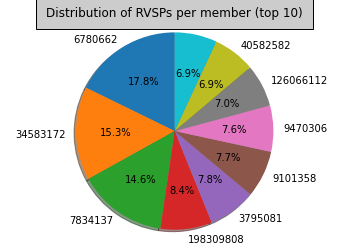

In [ ]:
fig1, ax1 = plt.subplots()
#ax1.pie(df_rsvps_per_member.head(10)['count'], labels=df_rsvps_per_member['member_id'].head(10), autopct='%1.1f%%', textprops={'color':"w"}, shadow=True, startangle=90)
ax1.pie(df_rsvps_per_member.head(10)['count'], labels=df_rsvps_per_member['member_id'].head(10), autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Distribution of RVSPs per member (top 10)", bbox={'facecolor':'0.8', 'pad':10})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#print(df_rsvps_per_member.head(10))
plt.show()

###**Plotting details about user with id 6780662**

The following pie charts shows the distribution of events (either by group/organizer, day, or location)

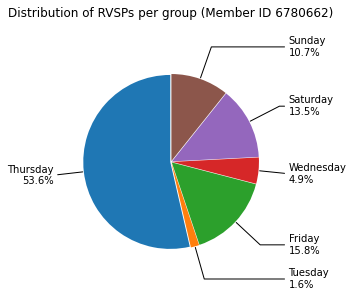

In [ ]:
df_merged_to_plot = df_merged[df_merged['member_id'] == 6780662]

sum_events_per_group = {}
sum_events_per_location = {}
sum_events_per_day = {}
for index,row in df_merged_to_plot.iterrows():
  #Getting total counts per day per event a specific member attended
  datetime_str = row['event_time'].split(' ')
  day_of_week = datetime.datetime.strptime(datetime_str[0], '%m/%d/%Y').strftime('%A')

  if day_of_week not in sum_events_per_day:
    sum_events_per_day[day_of_week] = 1
  else:
    sum_events_per_day[day_of_week] += 1
  #Getting total counts per location per event a specific member attended

  if row['member_city'] not in sum_events_per_location:
    sum_events_per_location[row['member_city']] = 1
  else:
    sum_events_per_location[row['member_city']] += 1
  
  #Getting total counts per group per event a specific member attended

  if row['group_id'] not in sum_events_per_group:
    sum_events_per_group[row['group_id']] = 1
  else:
    sum_events_per_group[row['group_id']] += 1
# Data to plot
labels = []
sizes = []
for x, y in sum_events_per_day.items():
    labels.append(x)
    sizes.append(y)
#print(sum_events_per_day)

bbox_props=dict(boxstyle='square,pad=0.3',fc ='w',ec='k',lw=0.72)
kw=dict(xycoords='data',textcoords='data',arrowprops=dict(arrowstyle='-'),zorder=0,va='center')

fig1,ax1=plt.subplots()
labels=["Wednesday\n4.9%","Tuesday\n1.6%","Saturday\n13.5%","Thursday\n53.6%","Sunday\n10.7%","Friday\n15.8%"]
values=sizes
# Add code
annotate_dict = {k:v for k,v in zip(labels, values)}
val = [[x,y] for x,y in zip(sorted(values, reverse=True),sorted(values))]
values1 = sum(val, [])

new_labels = []
for v in values1[:len(values)]:
    for key, value in annotate_dict.items():
        if v == value:
            new_labels.append(key)
            
wedges,texts=ax1.pie(values1[:len(values)],explode=[0.01,0.01,0.01,0.01,0.01,0.01],labeldistance=1.2,startangle=90)
for i,p in enumerate(wedges):
    ang=(p.theta2-p.theta1)/2. +p.theta1
    y=np.sin(np.deg2rad(ang))
    x=np.cos(np.deg2rad(ang))
    horizontalalignment={-1:"right",1:"left"}[int(np.sign(x))]
    connectionstyle="angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle":connectionstyle})
    ax1.annotate(new_labels[i],xy=(x, y),xytext=(1.35*np.sign(x),1.4*y),
                horizontalalignment=horizontalalignment,**kw)

plt.title("Distribution of RVSPs per group (Member ID 6780662)\n\n")
plt.show()

{'Nashville': 513}


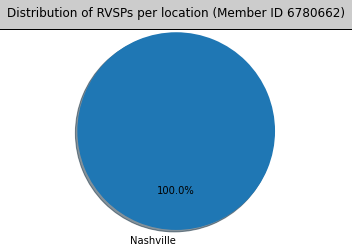

In [ ]:
# Data to plot
labels = []
sizes = []
for x, y in sum_events_per_location.items():
    labels.append(x)
    sizes.append(y)
print(sum_events_per_location)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Distribution of RVSPs per location (Member ID 6780662)", bbox={'facecolor':'0.8', 'pad':10})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

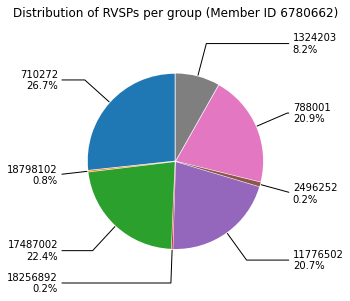

In [ ]:
# Data to plot
labels = []
sizes = []
for x, y in sum_events_per_group.items():
    labels.append(x)
    sizes.append(y)
#print(sum_events_per_group)

bbox_props=dict(boxstyle='square,pad=0.3',fc ='w',ec='k',lw=0.72)
kw=dict(xycoords='data',textcoords='data',arrowprops=dict(arrowstyle='-'),zorder=0,va='center')

fig1,ax1=plt.subplots()
labels=["710272\n26.7%","18798102\n0.8%","17487002\n22.4%","18256892\n0.2%","11776502\n20.7%","2496252\n0.2%","788001\n20.9%","1324203\n8.2%"]
values=sizes
# Add code
annotate_dict = {k:v for k,v in zip(labels, values)}
val = [[x,y] for x,y in zip(sorted(values, reverse=True),sorted(values))]
values1 = sum(val, [])

new_labels = []
for v in values1[:len(values)]:
    for key, value in annotate_dict.items():
        if v == value:
            new_labels.append(key)

wedges,texts=ax1.pie(values1[:len(values)],explode=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01],labeldistance=1.2,startangle=90)
for i,p in enumerate(wedges):
    ang=(p.theta2-p.theta1)/2. +p.theta1
    y=np.sin(np.deg2rad(ang))
    x=np.cos(np.deg2rad(ang))
    horizontalalignment={-1:"right",1:"left"}[int(np.sign(x))]
    connectionstyle="angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle":connectionstyle})
    ax1.annotate(labels[i],xy=(x, y),xytext=(1.35*np.sign(x),1.4*y),
                horizontalalignment=horizontalalignment,**kw)

plt.title("Distribution of RVSPs per group (Member ID 6780662)\n\n")
plt.show()

#**Assigning weights**

In the following code, we'll iterate over each member, and assign a weight on each of the events the user has attended. This value will be based on:

*   The distribution of events per group
*   The location
*   Day of the week




In [ ]:
#This will be used to feed the CNN
df_input_labels = pd.DataFrame(columns = ['member_id','event_id','weighted_score'])

#We split the dataset per member, so we can assign a weight score based on the variables previously mentioned
df_merged_per_frequent_member = []

for i in range(len(frequent_members_list)):
  df_merged_per_frequent_member.append(df_merged[df_merged['member_id'] == frequent_members_list[i]])


for i in range(len(frequent_members_list)):
  sum_events_per_group = {}
  sum_events_per_location = {}
  sum_events_per_day = {}
  for index,row in df_merged_per_frequent_member[i].iterrows():
    #Getting total counts per day per event a specific member attended
    datetime_str = row['event_time'].split(' ')
    day_of_week = datetime.datetime.strptime(datetime_str[0], '%m/%d/%Y').strftime('%A')

    if day_of_week not in sum_events_per_day:
      sum_events_per_day[day_of_week] = 1
    else:
      sum_events_per_day[day_of_week] += 1
    #Getting total counts per location per event a specific member attended

    if row['member_city'] not in sum_events_per_location:
      sum_events_per_location[row['member_city']] = 1
    else:
      sum_events_per_location[row['member_city']] += 1
    
    #Getting total counts per group per event a specific member attended

    if row['group_id'] not in sum_events_per_group:
      sum_events_per_group[row['group_id']] = 1
    else:
      sum_events_per_group[row['group_id']] += 1

  #print("Distribution of events (by location, day, and group) for the member with ID: "+str(frequent_members_list[i]))
  #print(sum_events_per_day)
  #print(sum_events_per_location)
  #print(sum_events_per_group)

  #Now that we obtained the distribution (by group, location and day), we proceed to calculate the Entropy
  #𝑬𝒏𝒕𝒓𝒐𝒑𝒚 = 𝚺 -𝑃(𝐼) ∗ logn(𝑃(𝐼)) 

  entropy_group = 0
  entropy_day = 0
  entropy_location = 0

  prob_i_group = {}
  prob_i_day = {}
  prob_i_location = {}

  #We start calculating the entropy for group
  for key in sum_events_per_group:
    Prob_I = (sum_events_per_group[key]/len(df_merged_per_frequent_member[i]))
    prob_i_group[key] = Prob_I
    if Prob_I == 1.0:
      entropy_group = 0
      break
    entropy_group += -Prob_I*math.log(Prob_I, len(sum_events_per_group))
  
  #We start calculating the entropy for day
  for key in sum_events_per_day:
    Prob_I = (sum_events_per_day[key]/len(df_merged_per_frequent_member[i]))
    prob_i_day[key] = Prob_I
    if Prob_I == 1.0:
      entropy_day = 0
      break
    entropy_day += -Prob_I*math.log(Prob_I, len(sum_events_per_day))
  
  #We start calculating the entropy for location
  for key in sum_events_per_location:
    Prob_I = (sum_events_per_location[key]/len(df_merged_per_frequent_member[i]))
    prob_i_location[key] = Prob_I
    if Prob_I == 1.0:
      entropy_location = 0
      break
    entropy_location += -Prob_I*math.log(Prob_I, len(sum_events_per_location))
  
  #Now we assign the weights for each event a specific member attended, given the entropy and distribution
  for index,row in df_merged_per_frequent_member[i].iterrows():
    final_weight_per_event = 0.0
    group_temp = row['group_id']
    location_temp = row['member_city']
    datetime_str = row['event_time'].split(' ')
    day_of_week_temp = datetime.datetime.strptime(datetime_str[0], '%m/%d/%Y').strftime('%A')
    final_weight_per_event += (entropy_group - (entropy_group * prob_i_group[group_temp])+prob_i_group[group_temp])*5
    final_weight_per_event += (entropy_location - (entropy_location * prob_i_location[location_temp])+prob_i_location[location_temp])*5
    final_weight_per_event += (entropy_day - (entropy_day * prob_i_day[day_of_week_temp])+prob_i_day[day_of_week_temp])*5
    final_weight_per_event = final_weight_per_event/3

    df_input_labels.loc[len(df_input_labels.index)] = [row['member_id'], row['event_id'], final_weight_per_event] 


The following dataframe shows some weighted values obtained based on the member and event relationship, and considering the variables mentioned before (organizer, location, and day)

In [ ]:
df_input_labels.sort_values(['weighted_score'], ascending=True)


,member_id,event_id,weighted_score
14592,76644252,227847405,2.069219
32943,129186362,dpklnfyvnbzb,2.384049
30086,83272622,dbdcqfywnbfc,2.397757
34710,129875952,230055662,2.418676
24119,12597688,kkttxlywlbrb,2.420490
...,...,...,...
22710,79867612,243085153,5.000000
58557,45630562,wpzjwlywcbdc,5.000000
58558,45630562,wpzjwlywcblb,5.000000
69187,1127091,qwspfhywhbkb,5.000000


Some event ids may contain non-numeric values, therefore, we'll assign a random number for each of these events

In [ ]:
df_temp = df_input_labels[df_input_labels['event_id'].apply(lambda x: not x.isnumeric())]
df_non_numeric_event_id = df_temp.value_counts(subset=['event_id']).to_frame()
df_non_numeric_event_id = df_non_numeric_event_id[0].reset_index(name="count")
non_numeric_event_list = df_non_numeric_event_id['event_id'].to_list()
#We get the max value of an event id, so we can start assigning a number from there
df_temp_2 = df_input_labels[df_input_labels['event_id'].apply(lambda x: x.isnumeric())]
event_id_max_value = df_temp_2['event_id'].max()

new_events_id = {}

starting_value = int(event_id_max_value)+1
for i in range(len(non_numeric_event_list)):
  new_events_id[non_numeric_event_list[i]] = starting_value
  starting_value +=1

for index,row in df_input_labels.iterrows():
  if row['event_id'] in new_events_id:
    df_input_labels.at[index,'event_id'] = new_events_id[row['event_id']]

Reordering and reassigning the member ids and event ids (so there aren't any empty values between these numbers)

In [ ]:
df_input_labels['member_id'] = df_input_labels['member_id'].astype('int')
df_input_labels['event_id'] = df_input_labels['event_id'].astype('int')

#Reordering the member_ids
df_input_labels_sorted_member_id = df_input_labels.sort_values('member_id')
df_input_labels_sorted_member_id = df_input_labels_sorted_member_id.value_counts(subset=['member_id']).to_frame()
df_ordered_member_list = df_input_labels_sorted_member_id[0].reset_index(name="count")
df_ordered_member_list = df_ordered_member_list['member_id'].to_list()

#Reordering the events_ids
df_input_labels_sorted_event_id = df_input_labels.sort_values('event_id')
df_input_labels_sorted_event_id = df_input_labels_sorted_event_id.value_counts(subset=['event_id']).to_frame()
df_ordered_event_list = df_input_labels_sorted_event_id[0].reset_index(name="count")
df_ordered_event_list = df_ordered_event_list['event_id'].to_list()

for i in range(len(df_ordered_member_list)):
  df_input_labels.loc[(df_input_labels.member_id == df_ordered_member_list[i]),'member_id']= i

for i in range(len(df_ordered_event_list)):
  df_input_labels.loc[(df_input_labels.event_id == df_ordered_event_list[i]),'event_id']= i

df_input_labels.sort_values('member_id')

,member_id,event_id,weighted_score
0,0,8707,4.231284
350,0,7847,4.530917
349,0,12038,4.353516
348,0,8346,4.530917
347,0,12132,4.364806
...,...,...,...
71875,2694,1069,4.739229
71873,2694,2836,4.789471
71872,2694,1816,4.739229
71870,2694,2481,4.739229


#**Building and training the Convolutional Neural Network**

CNN's fine-tuning parameters:
*   **128** neurons for the first hidden layer
*   **32** neurons for the second hidden layer
*   **1** neuron for the output layer
*   **Number of epochs:** 5

Three separated training process were carried out by using the following training/validation/testing ratios:
*   **80%** for training, **10%** for validation, **10%** for testing
*   **60%** for training, **20%** for validation, **20%** for testing
*   **40%** for training, **30%** for validation, **30%** for testing




In [ ]:
#80% for training, 10% for validation, 10% for testing
np.random.seed(42)
train, test = train_test_split(df_input_labels, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.1*(1/0.9), random_state=42)

# creating event embedding path
event_input = Input(shape=[1], name="Event-Input")
event_embedding = Embedding(df_input_labels['event_id'].max()+1, 20, name="Event-Embedding")(event_input)
event_vec = Flatten(name="Flatten-Events")(event_embedding)
# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(df_input_labels['member_id'].max()+1, 20, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
# concatenate features
conc = Concatenate()([event_vec, user_vec])
# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)
# Create model and compile it
model2 = Model([user_input, event_input], out)
model2.compile('adam', 'mean_squared_error')

history = model2.fit([train.member_id, train.event_id], train.weighted_score, epochs=5, verbose=1)

predictions = model2.predict([train.member_id, train.event_id])
print("Training 80%| Validation 10% | Testing 10%")
print("Root mean square error (Training): "+str(mean_squared_error(train.weighted_score, predictions, squared=False)))
predictions = model2.predict([val.member_id, val.event_id])
print("Root mean square error (Validation): "+str(mean_squared_error(val.weighted_score, predictions, squared=False)))
predictions = model2.predict([test.member_id, test.event_id])
print("Root mean square error (Testing): "+str(mean_squared_error(test.weighted_score, predictions, squared=False)))

Epoch 1/5
1800/1800 [==============================] - 6s 3ms/step - loss: 0.5172
Epoch 2/5
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0279
Epoch 3/5
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0215
Epoch 4/5
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0164
Epoch 5/5
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0131
Training 80%| Validation 10% | Testing 10%
Root mean square error (Training): 0.09900727375240272
Root mean square error (Validation): 0.15939181211392206
Root mean square error (Testing): 0.1753007876854568


In [ ]:
#60% for training, 20% for validation, 20% for testing
train, test = train_test_split(df_input_labels, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2*(1/0.8), random_state=42)
history = model2.fit([train.member_id, train.event_id], train.weighted_score, epochs=5, verbose=1)
predictions = model2.predict([train.member_id, train.event_id])
print("Training 60%| Validation 20% | Testing 20%")
print("Root mean square error (Training): "+str(mean_squared_error(train.weighted_score, predictions, squared=False)))
predictions = model2.predict([val.member_id, val.event_id])
print("Root mean square error (Validation): "+str(mean_squared_error(val.weighted_score, predictions, squared=False)))
predictions = model2.predict([test.member_id, test.event_id])
print("Root mean square error (Testing): "+str(mean_squared_error(test.weighted_score, predictions, squared=False)))

Epoch 1/5
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0123
Epoch 2/5
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0088
Epoch 3/5
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0070
Epoch 4/5
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0059
Epoch 5/5
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0050
Training 60%| Validation 20% | Testing 20%
Root mean square error (Training): 0.06061719098884168
Root mean square error (Validation): 0.12646004129472824
Root mean square error (Testing): 0.15047785621410392


In [ ]:
#40% for training, 30% for validation, 30% for testing
train, test = train_test_split(df_input_labels, test_size=0.3, random_state=42)
train, val = train_test_split(train, test_size=0.3*(1/0.7), random_state=42)
history = model2.fit([train.member_id, train.event_id], train.weighted_score, epochs=5, verbose=1)
predictions = model2.predict([train.member_id, train.event_id])
print("Training 40%| Validation 30% | Testing 30%")
print("Root mean square error (Training): "+str(mean_squared_error(train.weighted_score, predictions, squared=False)))
predictions = model2.predict([val.member_id, val.event_id])
print("Root mean square error (Validation): "+str(mean_squared_error(val.weighted_score, predictions, squared=False)))
predictions = model2.predict([test.member_id, test.event_id])
print("Root mean square error (Testing): "+str(mean_squared_error(test.weighted_score, predictions, squared=False)))


Epoch 1/5
900/900 [==============================] - 3s 3ms/step - loss: 0.0080
Epoch 2/5
900/900 [==============================] - 3s 3ms/step - loss: 0.0048
Epoch 3/5
900/900 [==============================] - 3s 3ms/step - loss: 0.0034
Epoch 4/5
900/900 [==============================] - 3s 3ms/step - loss: 0.0029
Epoch 5/5
900/900 [==============================] - 3s 3ms/step - loss: 0.0028
Training 40%| Validation 30% | Testing 30%
Root mean square error (Training): 0.047898977762404635
Root mean square error (Validation): 0.09789680272862238
Root mean square error (Testing): 0.13475129673273237
